<a href="https://colab.research.google.com/github/hoonzi-s/APC/blob/main/%231ALK_213BTMRVP_R6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

## Get Data

In [66]:
data_origin = pd.read_csv('https://raw.githubusercontent.com/hoonzi-s/APC/main/%231%20ALK%20RVP%20CSV.csv', index_col = 0)
data_origin.info()
data_origin.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 4646 entries, 2009-09-01 13:00:00 to 2022-06-30 7:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RVP_LAB         4646 non-null   float64
 1   S.B5.213TI2804  4646 non-null   float64
 2   S.B5.213PI2806  4646 non-null   float64
 3   S.B5.213FC2602  4646 non-null   float64
 4   S.B5.213FC2901  4646 non-null   float64
dtypes: float64(5)
memory usage: 217.8+ KB


,RVP_LAB,S.B5.213TI2804,S.B5.213PI2806,S.B5.213FC2602,S.B5.213FC2901
count,4646.000000,4646.000000,4646.000000,4646.000000,4646.000000
mean,38.124064,138.044996,361.386711,89.372504,25.640245
std,4.011912,7.339579,50.481634,10.520158,4.325594
min,18.700000,80.196512,292.287587,35.108368,11.063002
25%,35.800000,132.655836,321.044334,85.121943,24.106756
50%,37.800000,135.984950,338.225252,91.152604,26.999690
75%,39.900000,142.093421,398.883919,95.626125,28.008802
max,98.600000,166.259238,494.574306,120.000000,37.977773


In [76]:
data_origin.columns = ['RVP', 'T', 'P', 'F', 'R']
data = data_origin[(data_origin.iloc[:, 0] < 70) & (data_origin.iloc[:, 1] > 120)]
data['RF'] = data['R'] / data['F']
data = data.iloc[1100:, :]
# x = data[['T', 'P', 'F', 'R', 'RF']]
x = data[['T', 'P', 'F', 'RF']]
y = data['RVP']
# data.iloc[:, 1] += 273.15     # to Absolute
# data.iloc[:, 2] += 101.325    # to Absolute
# lab = data.iloc[:, 0]

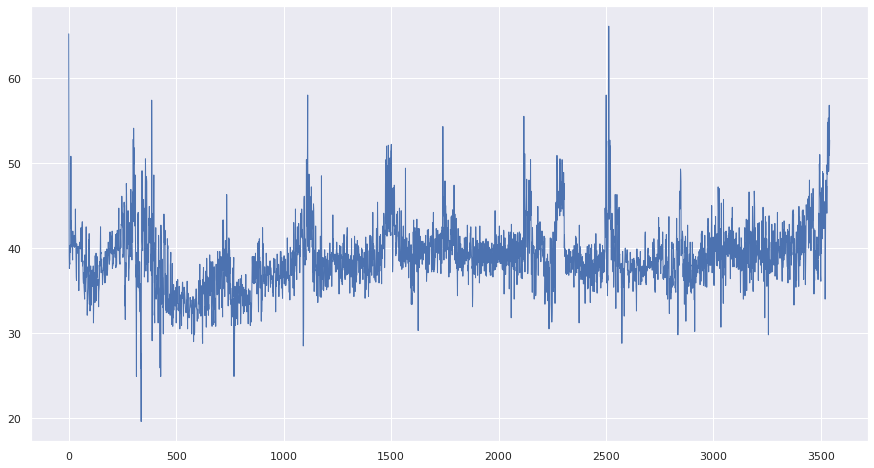

In [77]:
plt.figure(figsize = (15, 8))
plt.plot(np.arange(len(y)), data.RVP, lw = 1)
plt.show()

In [6]:
results = pd.DataFrame(columns=['Alpha', 'train_R2', 'test_R2', 'R2', 'MAE', 'MSE', 'coeffs', 'intercept'])
results

,Alpha,train_R2,test_R2,R2,MAE,MSE,coeffs,intercept


# LinearRegression

In [79]:
pf = PolynomialFeatures()
pf.fit(x)
x_poly = pf.transform(x)

sc = StandardScaler()
sc.fit(x_poly)
x_scaled = sc.transform(x_poly)

x_train, x_test, y_train, y_test = tts(x_scaled, y)

model = LinearRegression()
model.fit(x_train, y_train)
inf = model.predict(x_scaled)

print(f'train R2: {model.score(x_train, y_train)}')
print(f'test R2: {model.score(x_test, y_test)}')
print(f'total R2: {model.score(x_scaled, y)}')
print(f'MAE: {MAE(y, inf)}')
print(f'MSE: {MSE(y, inf)}')
print(model.coef_, model.intercept_)

train R2: 0.6101509836198378
test R2: 0.5832518255439615
total R2: 0.6030612656699396
MAE: 1.6256379104812677
MSE: 5.4687542608250865
[  0.           2.98155696  12.66618179   9.20583007   1.37651357
   1.57366488 -12.81125459 -16.45668023  -2.59859311   1.35403598
   2.34272833  -3.31934683   2.60226907   1.79196168   1.32986497] 38.914980212580154


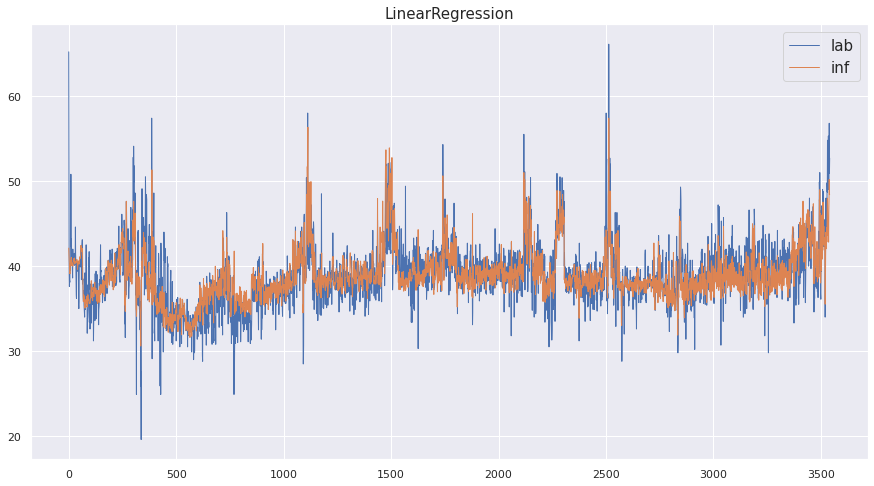

In [80]:
plt.figure(figsize = (15, 8))
plt.plot(np.arange(len(y)), y, lw = 1, label = 'lab')
plt.plot(np.arange(len(y)), inf, lw = 1, label = 'inf')
plt.title('LinearRegression', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

# Lasso

In [81]:
for alpha in np.arange(0.001, 0.031, 0.001):
  
  train_r2 = []
  test_r2 = []
  total_r2 = []
  zeros = []
  mae = []
  mse = []

  for n in range(10):
    pf = PolynomialFeatures()
    pf.fit(x)
    x_poly = pf.transform(x)

    sc = StandardScaler()
    sc.fit(x_poly)
    x_scaled = sc.transform(x_poly)

    x_train, x_test, y_train, y_test = tts(x_scaled, y)

    model = Lasso(alpha = alpha, max_iter = 100000)
    model.fit(x_train, y_train)
    inf = model.predict(x_scaled)

    train_r2.append(model.score(x_train, y_train))
    test_r2.append(model.score(x_test, y_test))
    total_r2.append(model.score(x_scaled, y))
    zeros.append(np.sum(model.coef_==0))
    mae.append(MAE(y, inf))
    mse.append(MSE(y, inf))

  print(f'alpha: {alpha:.3f}, zeros: {np.mean(zeros)}')
  print(f'train R2: {np.mean(train_r2)}')
  print(f'test R2: {np.mean(test_r2)}')
  print(f'total R2: {np.mean(total_r2)}')
  print(f'MAE: {np.mean(mae)}')
  print(f'MSE: {np.mean(mse)}')
  # print(model.coef_, model.intercept_)
  print()

alpha: 0.001, zeros: 4.9
train R2: 0.6060337595313687
test R2: 0.5980782835405161
total R2: 0.6040141328654235
MAE: 1.626088277240355
MSE: 5.4556262990400075

alpha: 0.002, zeros: 6.2
train R2: 0.6064350702665104
test R2: 0.5928168239134273
total R2: 0.6033268012094134
MAE: 1.629820444320109
MSE: 5.4650958911894065

alpha: 0.003, zeros: 6.6
train R2: 0.6049948288896025
test R2: 0.5917275290399349
total R2: 0.6018693421568007
MAE: 1.6309952624640474
MSE: 5.485175779380227

alpha: 0.004, zeros: 6.9
train R2: 0.603200397361604
test R2: 0.5931424705046021
total R2: 0.6012731016443696
MAE: 1.6323335645822035
MSE: 5.493390379168119

alpha: 0.005, zeros: 7.2
train R2: 0.6017685617563752
test R2: 0.5909275589293268
total R2: 0.5993341730327456
MAE: 1.6388454917792994
MSE: 5.520103630330547

alpha: 0.006, zeros: 7.2
train R2: 0.6019573939718936
test R2: 0.5895033451051969
total R2: 0.5987978779742626
MAE: 1.6413960676175499
MSE: 5.527492342069875

alpha: 0.007, zeros: 7.7
train R2: 0.5970877275

In [82]:
for alpha in np.arange(0.001, 0.031, 0.001):
  
  train_r2 = []
  test_r2 = []
  total_r2 = []
  zeros = []
  mae = []
  mse = []

  for n in range(10):
    pf = PolynomialFeatures()
    pf.fit(x)
    x_poly = pf.transform(x)

    sc = StandardScaler()
    sc.fit(x)
    x_scaled = sc.transform(x)

    x_train, x_test, y_train, y_test = tts(x_scaled, y)

    model = Lasso(alpha = alpha, max_iter = 100000)
    model.fit(x_train, y_train)
    inf = model.predict(x_scaled)

    train_r2.append(model.score(x_train, y_train))
    test_r2.append(model.score(x_test, y_test))
    total_r2.append(model.score(x_scaled, y))
    zeros.append(np.sum(model.coef_==0))
    mae.append(MAE(y, inf))
    mse.append(MSE(y, inf))

  print(f'alpha: {alpha:.3f}, zeros: {np.mean(zeros)}')
  print(f'train R2: {np.mean(train_r2)}')
  print(f'test R2: {np.mean(test_r2)}')
  print(f'total R2: {np.mean(total_r2)}')
  print(f'MAE: {np.mean(mae)}')
  print(f'MSE: {np.mean(mse)}')
  # print(model.coef_, model.intercept_)
  print()

alpha: 0.001, zeros: 0.0
train R2: 0.5944806200720303
test R2: 0.5877684246230244
total R2: 0.5933408456498881
MAE: 1.6563581150417324
MSE: 5.602675654239579

alpha: 0.002, zeros: 0.0
train R2: 0.5927913543552732
test R2: 0.594199785330138
total R2: 0.5934391654625444
MAE: 1.6548336356181248
MSE: 5.601321070149175

alpha: 0.003, zeros: 0.0
train R2: 0.5981699090352929
test R2: 0.5789494384530918
total R2: 0.5932917937973743
MAE: 1.6566181697219826
MSE: 5.603351457592174

alpha: 0.004, zeros: 0.0
train R2: 0.5960663277251838
test R2: 0.5837066579226914
total R2: 0.593375919034002
MAE: 1.6552229482559582
MSE: 5.602192436800145

alpha: 0.005, zeros: 0.0
train R2: 0.5919942815174966
test R2: 0.5942304607781663
total R2: 0.5932247980366497
MAE: 1.6571528675399922
MSE: 5.604274480014105

alpha: 0.006, zeros: 0.0
train R2: 0.5959424924526484
test R2: 0.5856650092967385
total R2: 0.5934646035704241
MAE: 1.6561509549040907
MSE: 5.600970601049481

alpha: 0.007, zeros: 0.0
train R2: 0.59461994313

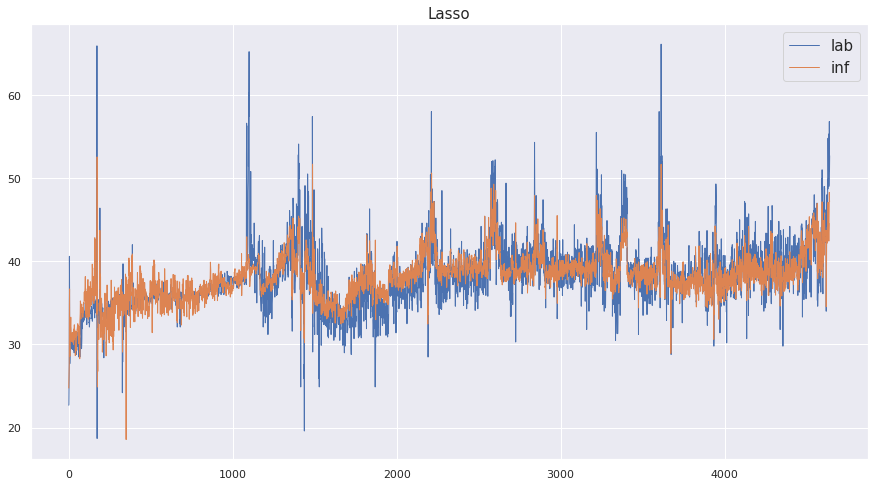

In [64]:
plt.figure(figsize = (15, 8))
plt.plot(np.arange(len(y)), y, lw = 1, label = 'lab')
plt.plot(np.arange(len(y)), inf, lw = 1, label = 'inf')
plt.title('Lasso', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [61]:
model.coef_

array([ 0.        , -1.66873973,  4.51853306, -0.        ,  0.        ,
       -4.19859808,  0.        , -0.32733299, -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.04420096])

In [63]:
pf.get_feature_names_out()

array(['1', 'T', 'P', 'F', 'RF', 'T^2', 'T P', 'T F', 'T RF', 'P^2',
       'P F', 'P RF', 'F^2', 'F RF', 'RF^2'], dtype=object)

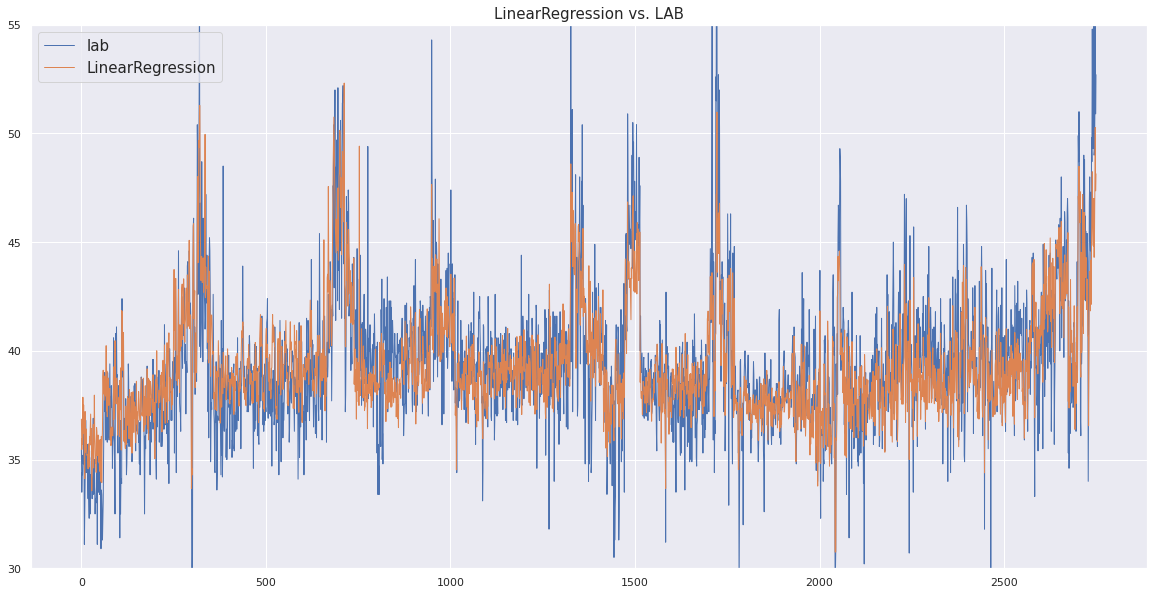

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), lab, label = 'lab', lw = 1)
plt.plot(np.arange(2750), inferential, label = 'LinearRegression', lw = 1)
plt.ylim(30, 55)
plt.legend(fontsize = 15)
plt.title('LinearRegression vs. LAB', fontsize = 15)
plt.savefig('inf_linearregression.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)
train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)

sc = StandardScaler()
sc.fit(train_input)
input_poly = sc.transform(input_poly)
train_poly = sc.transform(train_input)
test_poly = sc.transform(test_input)

xgb = XGBRegressor()
xgb.fit(train_poly, train_target)
print(f'train_R2: {xgb.score(train_poly, train_target)}')
print(f'test_R2: {xgb.score(test_poly, test_target)}')
print(f'R2: {r2_score(target, xgb.predict(input_poly))}')
inferential = xgb.predict(input_poly)
print(f'MAE: {MAE(target, inferential)}')
print(f'MSE: {MSE(target, inferential)}')

[04:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_R2: 0.6964234698463669
test_R2: 0.6072179783182994
R2: 0.671258164787376
MAE: 1.4269713883833453
MSE: 3.682392533653613


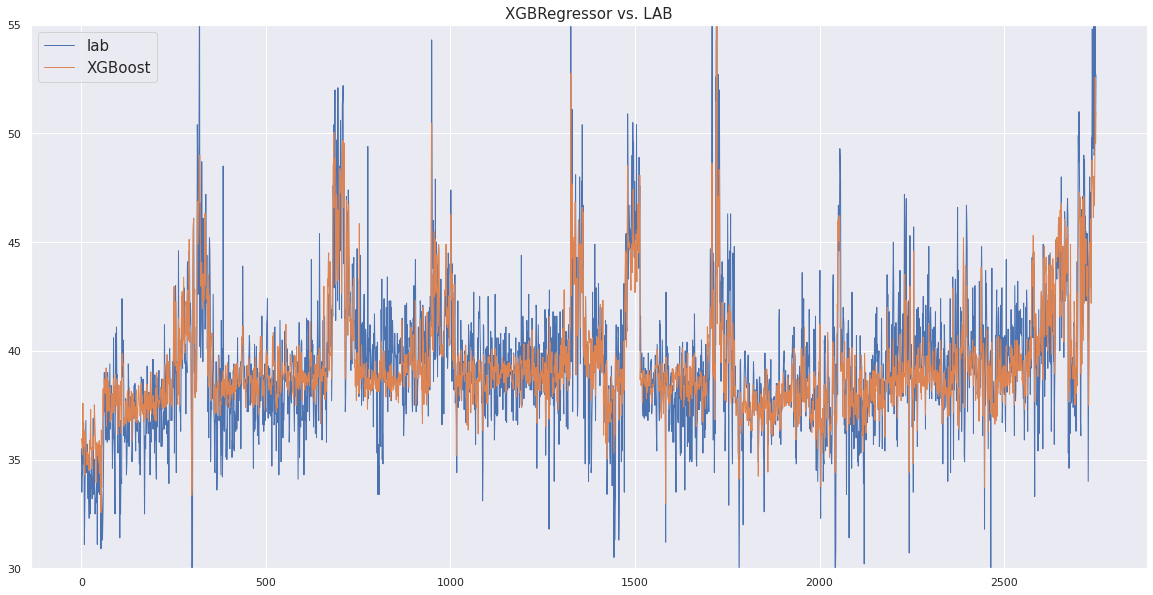

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, label = 'lab', lw = 1)
plt.plot(np.arange(2750), inferential, label = 'XGBoost', lw = 1)
plt.ylim(30, 55)
plt.legend(fontsize = 15)
plt.title('XGBRegressor vs. LAB', fontsize = 15)
plt.savefig('inf_xgbregressor.png', dpi = 300, bbox_inches = 'tight')
plt.show()